In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from itertools import cycle
import re
from scipy.linalg import pinv
from scipy.integrate import simpson

sns.set_theme()
sns.set_context("notebook")

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'HeatLoad': 'float',
    'CumulativeHeatLoad': 'float',
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTest.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-11-25,5b581702,SE-27c3257a-1492,773,DairyCross,1,32,202204,39.60,NaN,...,NaN,7.716053,0,0,0,0,1.50,37.235887,-23.764113,0.00000
1,2022-11-26,5b581702,SE-27c3257a-1492,774,DairyCross,1,33,202204,22.19,39.60,...,-0.546336,-9.676844,0,0,0,0,1.45,36.869260,-24.130740,0.00000
2,2022-11-27,5b581702,SE-27c3257a-1492,775,DairyCross,1,34,202204,29.40,22.19,...,0.226375,-2.449740,0,0,0,0,-0.15,30.678900,-30.321100,0.00000
3,2022-11-28,5b581702,SE-27c3257a-1492,776,DairyCross,1,35,202204,27.03,29.40,...,-0.074452,-4.802637,0,0,0,0,2.70,37.007500,-23.992500,0.00000
4,2022-11-29,5b581702,SE-27c3257a-1492,777,DairyCross,1,36,202204,26.88,27.03,...,-0.004715,-4.935533,0,0,0,0,2.85,38.536020,-22.463980,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289857,2024-07-20,f454e660,SE-f454e660-0797,1074,SLB,1,333,202403,21.46,20.53,...,0.044699,0.654045,1,1,0,0,18.60,58.426400,-2.573600,18.15392
289858,2024-07-21,f454e660,SE-f454e660-0797,1075,SLB,1,334,202403,15.76,21.46,...,-0.227750,-9.267434,1,1,0,0,18.20,64.590280,3.590280,21.74420
289859,2024-07-22,f454e660,SE-f454e660-0797,1076,SLB,1,335,202403,16.42,15.76,...,0.026929,-8.088825,1,1,0,0,17.90,64.658400,3.658400,25.40260
289860,2024-07-23,f454e660,SE-f454e660-0797,1077,SLB,1,336,202403,6.82,16.42,...,-0.413173,-16.414840,1,1,0,0,19.60,63.422440,2.422440,27.82504


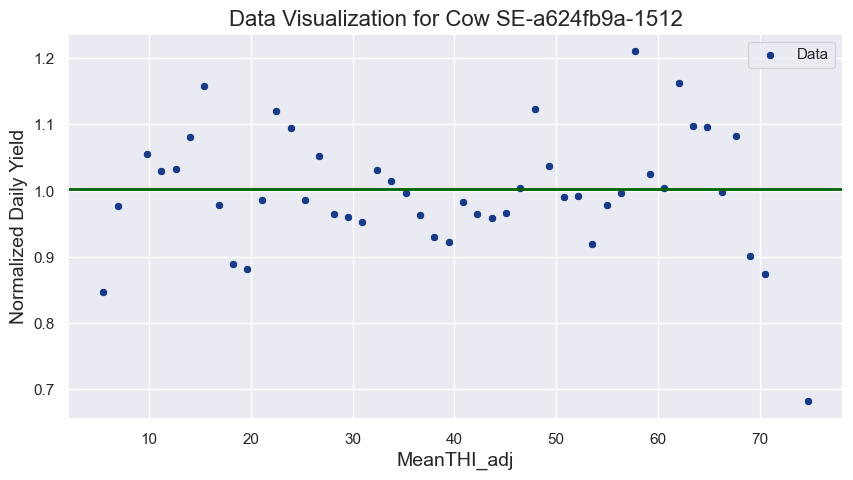

In [3]:
# Filter data for the specific farm
farm_id = 'a624fb9a'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

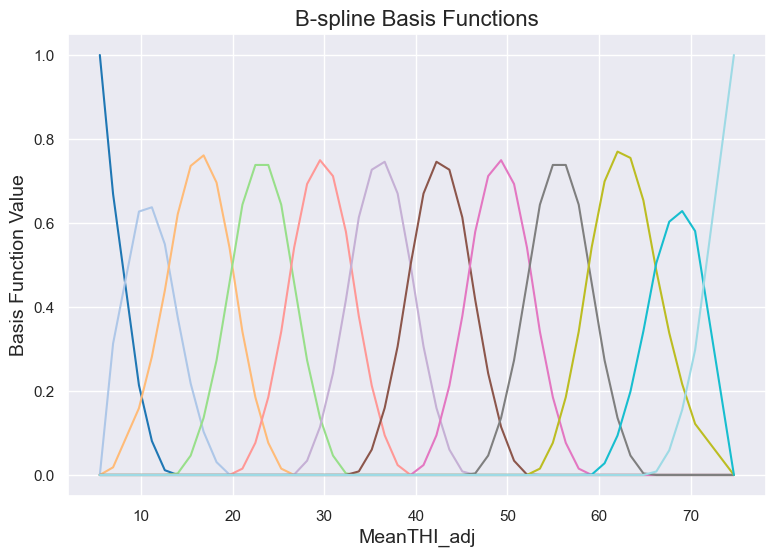

In [4]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-a624fb9a-1512 is 0.0033


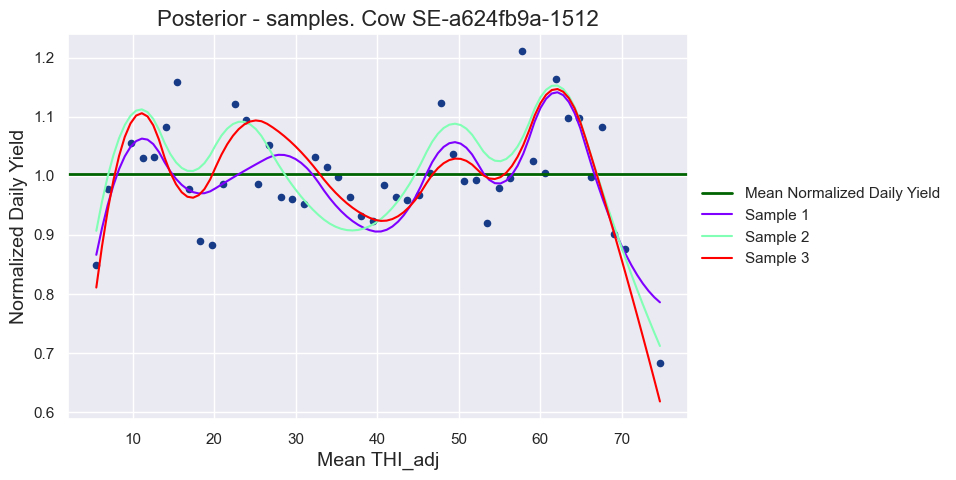

In [5]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

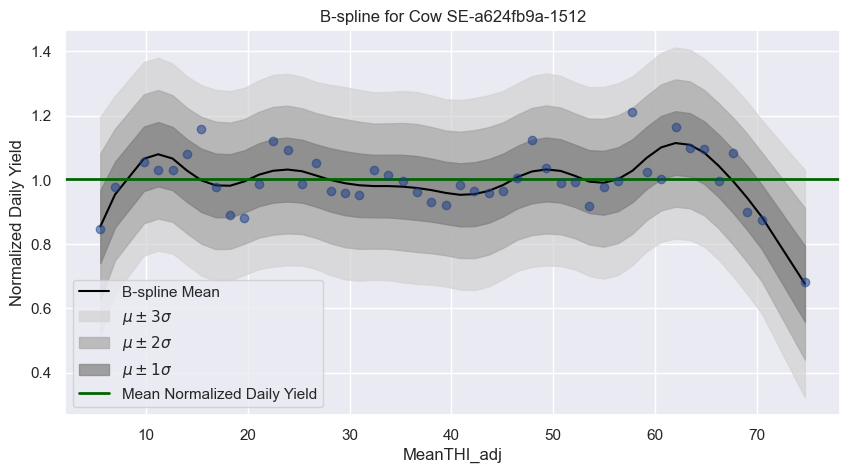

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,a624fb9a,SE-30dc5787-1389,-8.424959,-0.084250
1,a624fb9a,SE-a624fb9a-1162,0.218845,0.002188
2,a624fb9a,SE-a624fb9a-1193,-3.823513,-0.038235
3,a624fb9a,SE-a624fb9a-1199,-8.877311,-0.088773
4,a624fb9a,SE-a624fb9a-1200,-6.916511,-0.069165
...,...,...,...,...
118,a624fb9a,SE-a624fb9a-1433,-1.791988,-0.017920
119,a624fb9a,SE-a624fb9a-1440,-10.510048,-0.105100
120,a624fb9a,SE-a624fb9a-1463,-6.532088,-0.065321
121,a624fb9a,SE-a624fb9a-1493,1.878869,0.018789


In [6]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

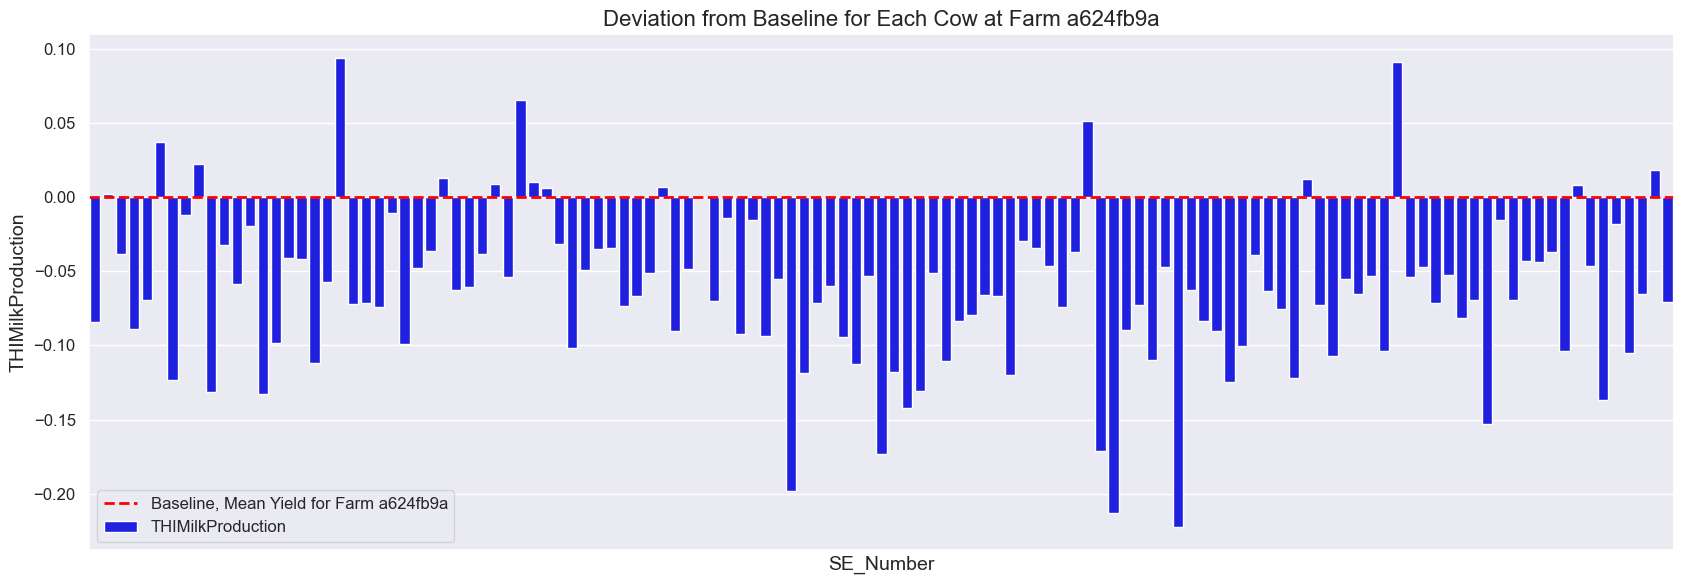

In [7]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

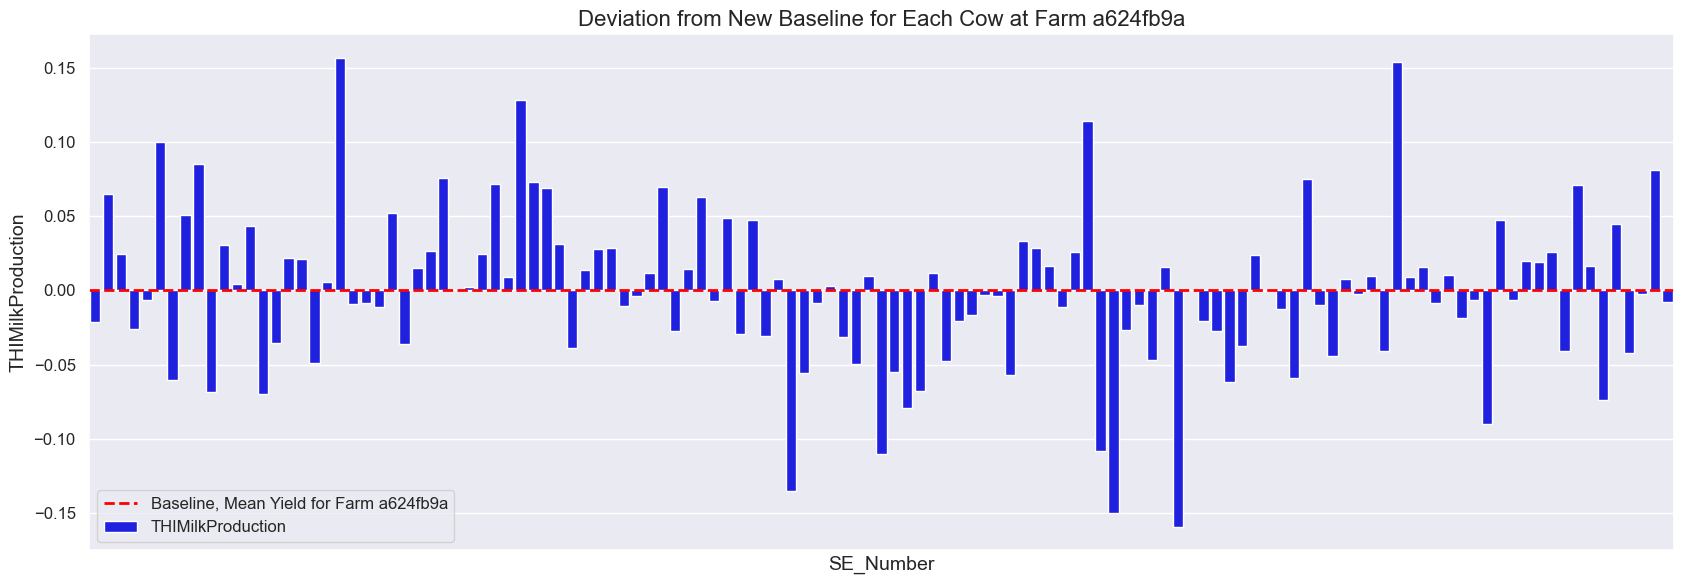

In [8]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5c06d92d

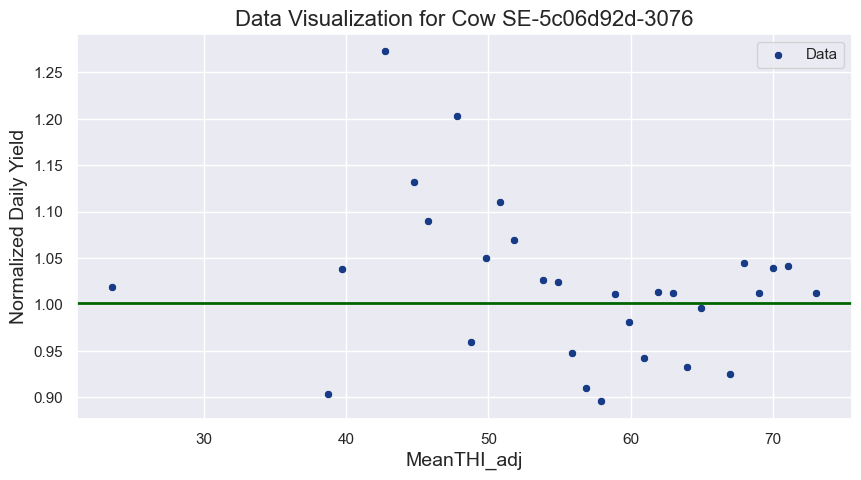

In [9]:
# Filter data for the specific farm
farm_id = '5c06d92d'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

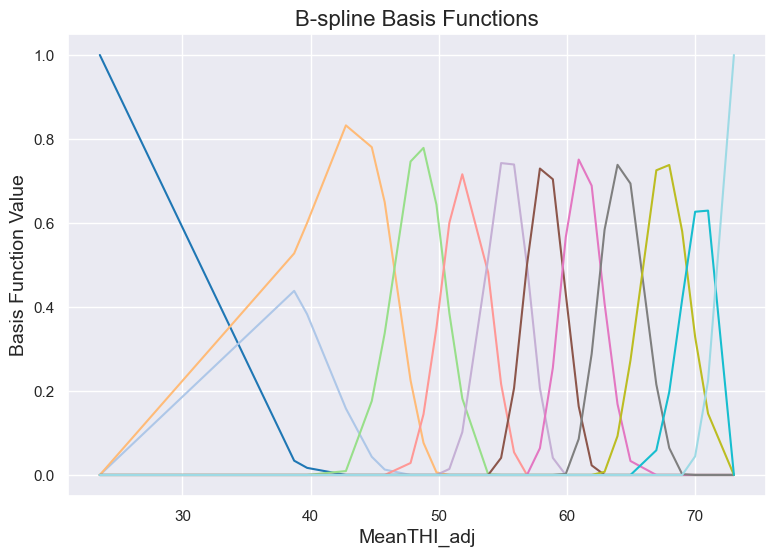

In [10]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-5c06d92d-3076 is 0.0026


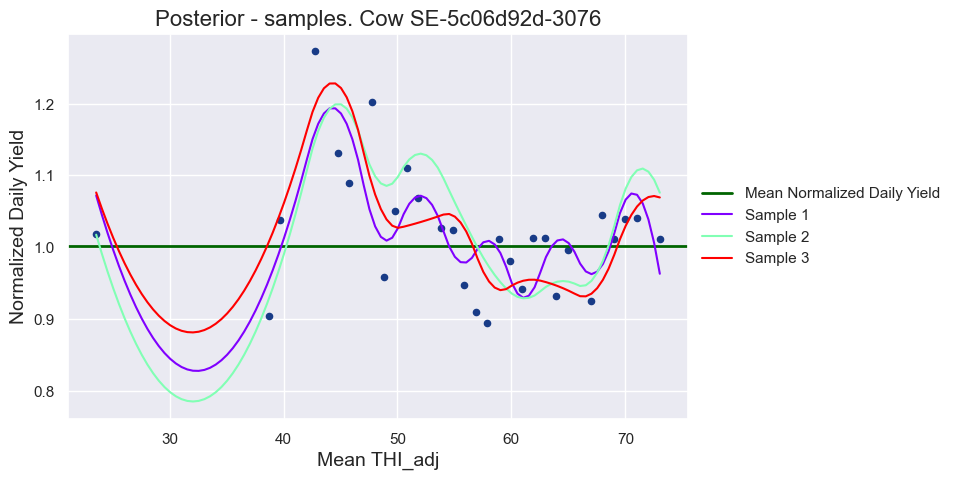

Skipping Cow SE-5c06d92d-3531 due to insufficient data points.
Skipping Cow SE-5c06d92d-3545 due to insufficient data points.
Skipping Cow SE-5c06d92d-3564 due to insufficient data points.
Skipping Cow SE-5c06d92d-3579 due to insufficient data points.
Skipping Cow SE-5c06d92d-3314 due to insufficient data points.


In [11]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-5c06d92d-2424 due to incompatible dimensions or another error: Incompatible dimensions (B: (5, 6))
Skipping Cow SE-5c06d92d-2515 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-5c06d92d-2577 due to incompatible dimensions or another error: Incompatible dimensions (B: (10, 11))
Skipping Cow SE-5c06d92d-2591 due to incompatible dimensions or another error: Incompatible dimensions (B: (11, 12))
Skipping Cow SE-5c06d92d-2657 due to incompatible dimensions or another error: Incompatible dimensions (B: (6, 7))
Skipping Cow SE-5c06d92d-2713 due to incompatible dimensions or another error: Incompatible dimensions (B: (10, 11))
Skipping Cow SE-5c06d92d-2724 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-5c06d92d-2731 due to incompatible dimensions or another error: Incompatible dimensions (B: (5, 6))
Skipping Cow SE-5c06d92d-2748 due to incompatible dimensions or another er

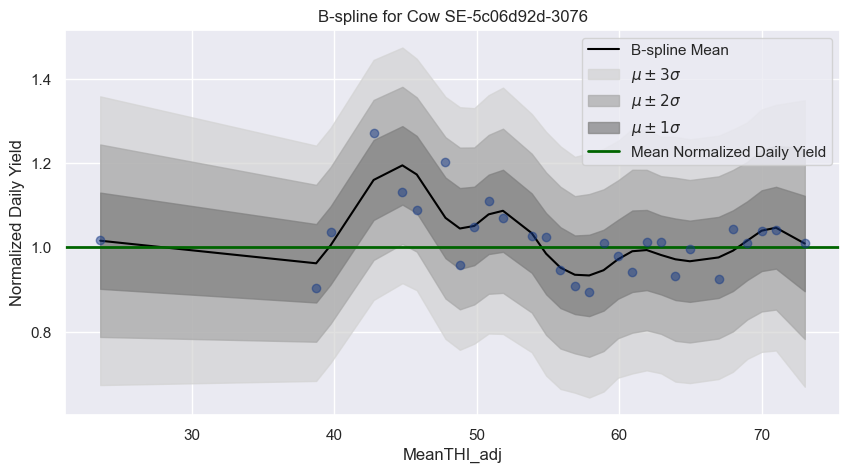

Skipping Cow SE-5c06d92d-3078 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-5c06d92d-3083 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-5c06d92d-3085 due to incompatible dimensions or another error: Incompatible dimensions (B: (9, 10))
Skipping Cow SE-5c06d92d-3099 due to incompatible dimensions or another error: Incompatible dimensions (B: (10, 11))
Skipping Cow SE-5c06d92d-3111 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-5c06d92d-3113 due to incompatible dimensions or another error: Incompatible dimensions (B: (3, 4))
Skipping Cow SE-5c06d92d-3114 due to incompatible dimensions or another error: Incompatible dimensions (B: (10, 11))
Skipping Cow SE-5c06d92d-3118 due to incompatible dimensions or another error: Incompatible dimensions (B: (11, 12))
Skipping Cow SE-5c06d92d-3119 due to incompatible dimensions or another e

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,5c06d92d,SE-5c06d92d-2333,-2.051705,-0.020517
1,5c06d92d,SE-5c06d92d-2514,1.901707,0.019017
2,5c06d92d,SE-5c06d92d-2536,-20.386026,-0.203860
3,5c06d92d,SE-5c06d92d-2569,-1.702229,-0.017022
4,5c06d92d,SE-5c06d92d-2621,2.067745,0.020677
...,...,...,...,...
194,5c06d92d,SE-5c06d92d-2932,-74.874317,-0.748743
195,5c06d92d,SE-5c06d92d-3225,0.564887,0.005649
196,5c06d92d,SE-5c06d92d-3374,-1.138115,-0.011381
197,5c06d92d,SE-5c06d92d-3424,-0.532376,-0.005324


In [12]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

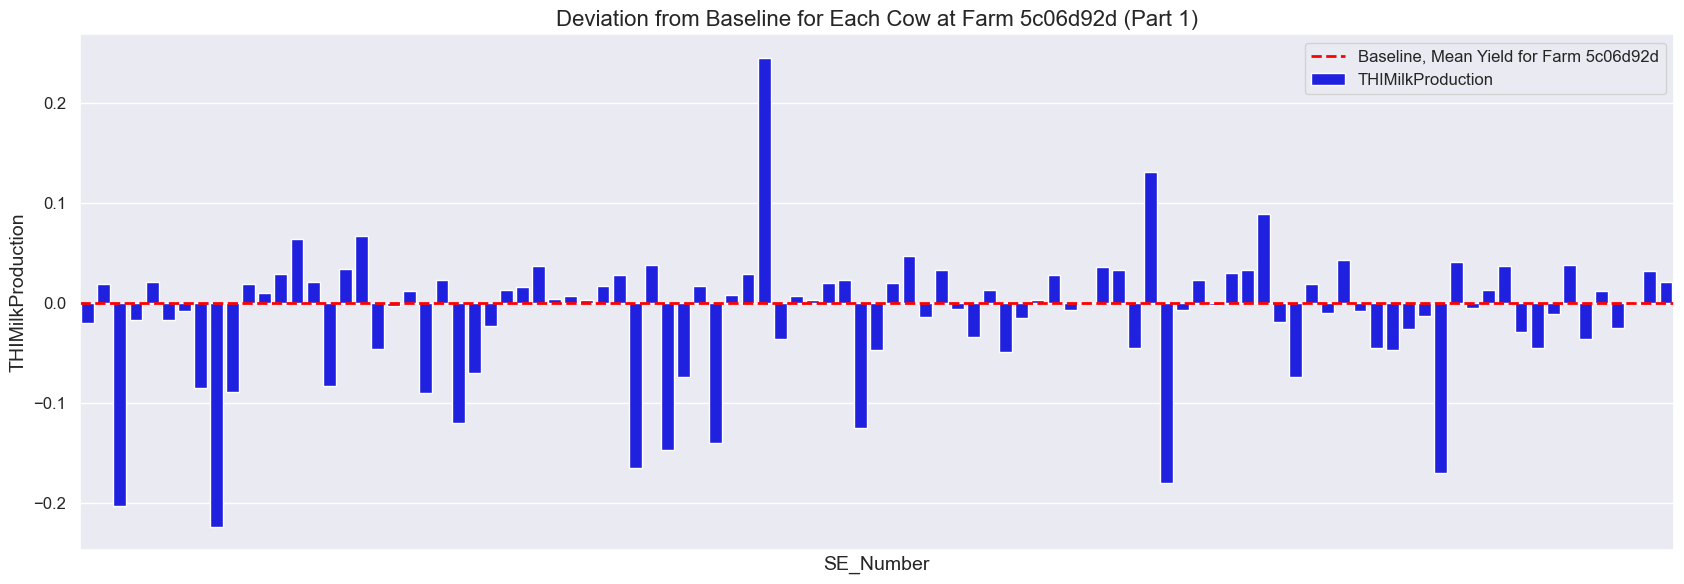

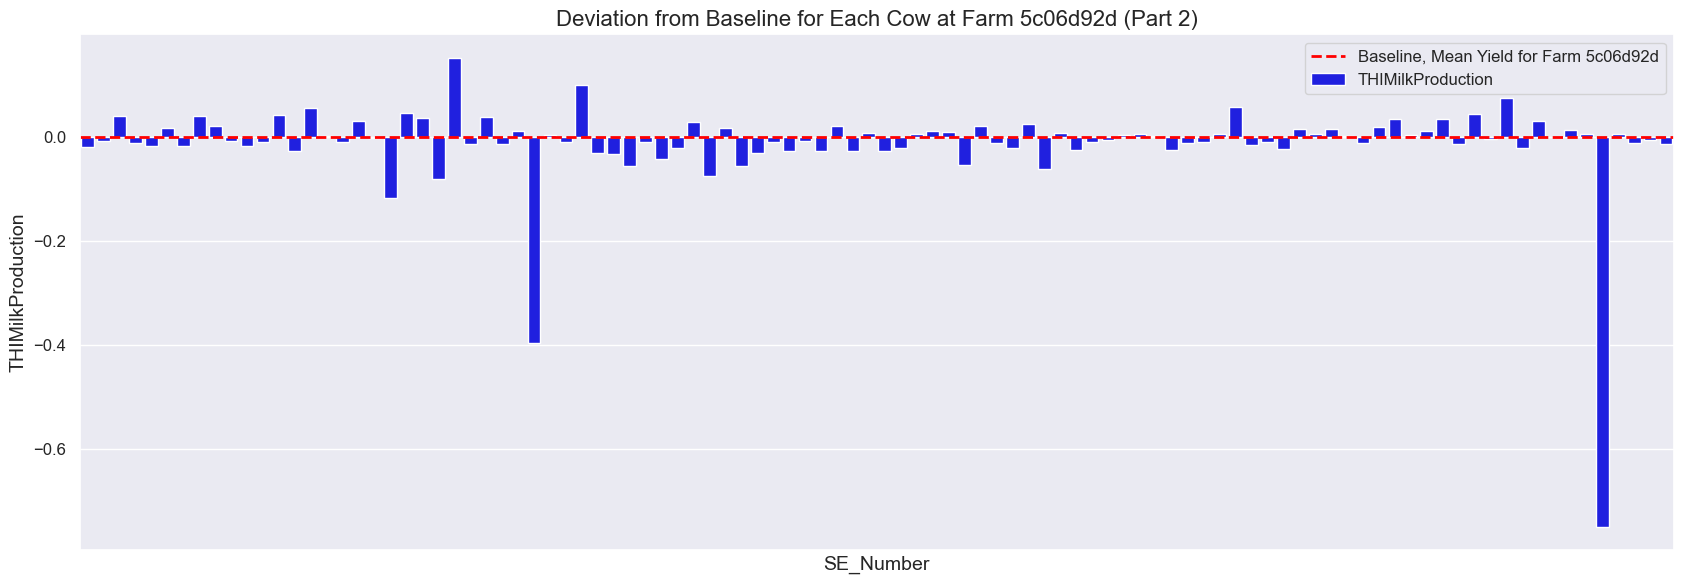

In [13]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

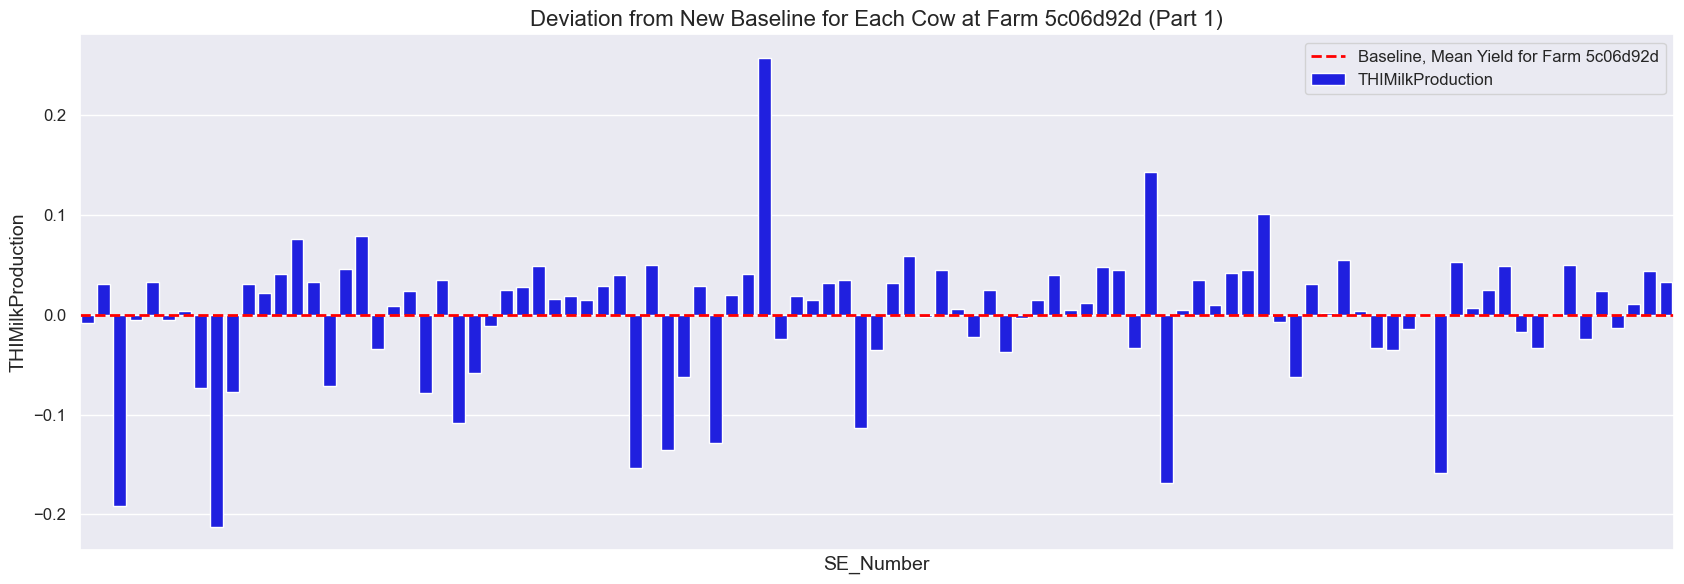

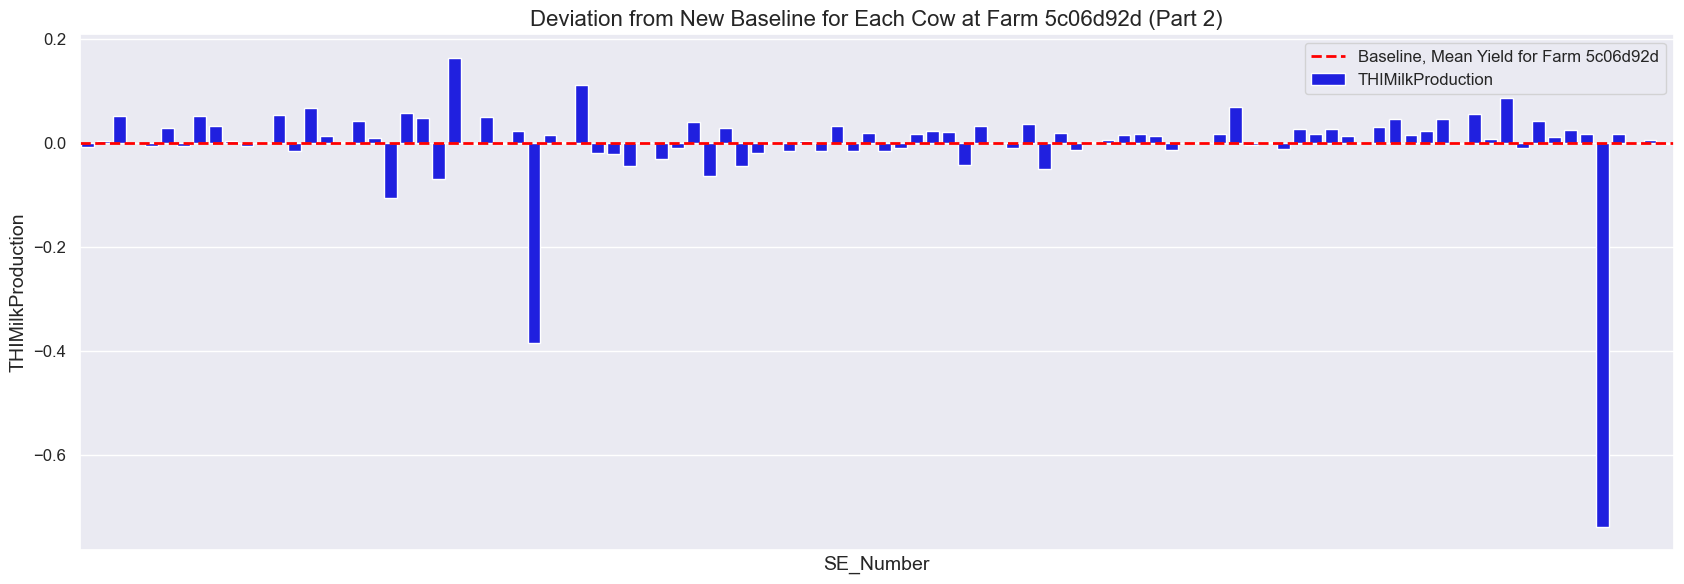

In [14]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72
- herd not in P. Ask-Gullstrand's cleaned dataset

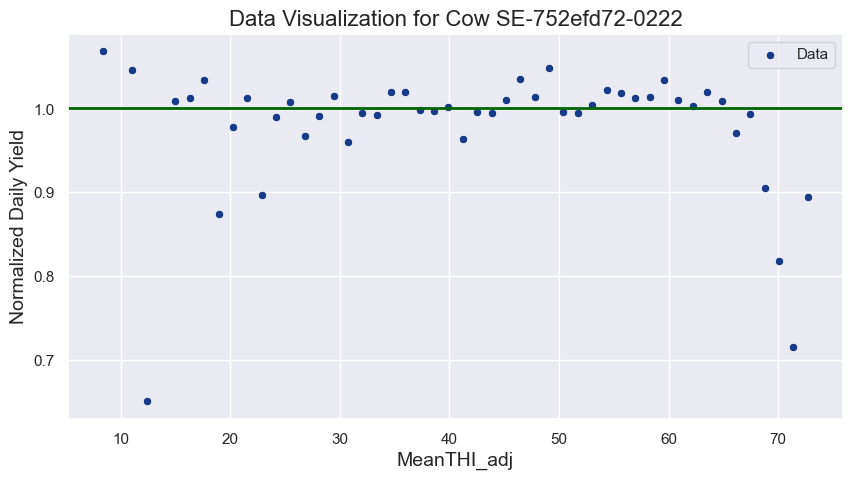

In [15]:
# Filter data for the specific farm
farm_id = '752efd72'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

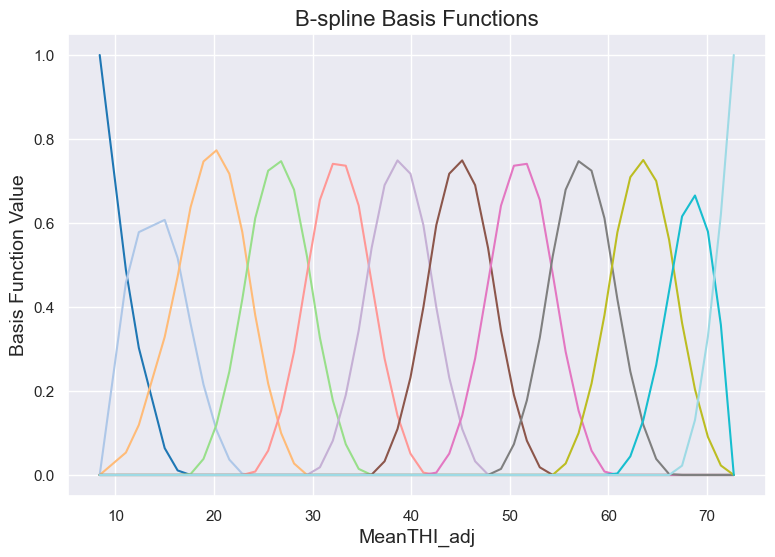

In [16]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-752efd72-0222 is 0.0034


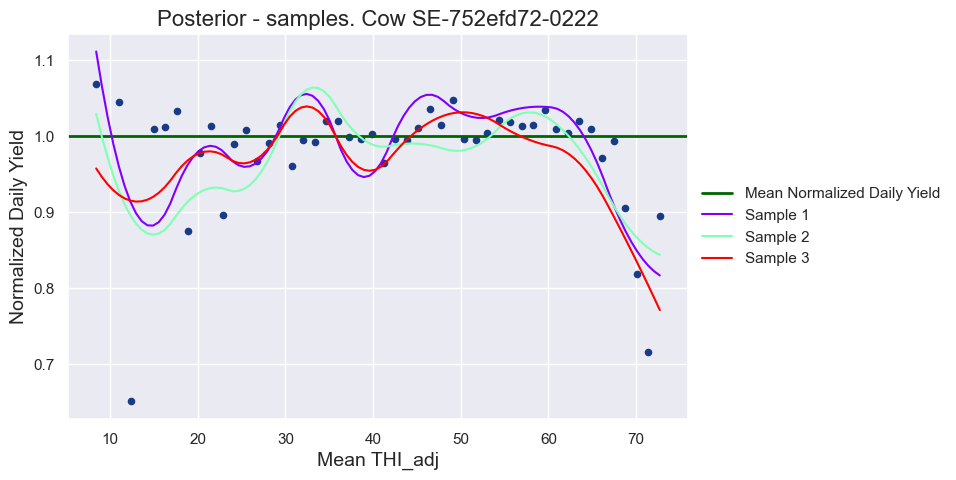

In [17]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-752efd72-0093 due to insufficient data points after filtering.


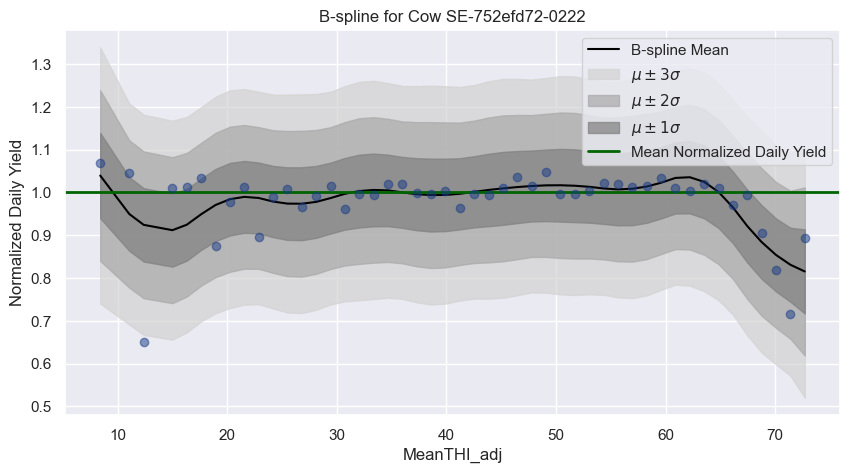

Skipping Cow SE-752efd72-2795 due to insufficient data points after filtering.


,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,752efd72,SE-752efd72-0001,-3.366610,-0.033666
1,752efd72,SE-752efd72-0002,7.096095,0.070961
2,752efd72,SE-752efd72-0008,-0.626645,-0.006266
3,752efd72,SE-752efd72-0010,-2.743902,-0.027439
4,752efd72,SE-752efd72-0011,-1.993399,-0.019934
...,...,...,...,...
396,752efd72,SE-752efd72-0345,-2.447161,-0.024472
397,752efd72,SE-752efd72-0450,-0.826783,-0.008268
398,752efd72,SE-752efd72-0468,-0.652259,-0.006523
399,752efd72,SE-752efd72-0469,-0.815849,-0.008158


In [18]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

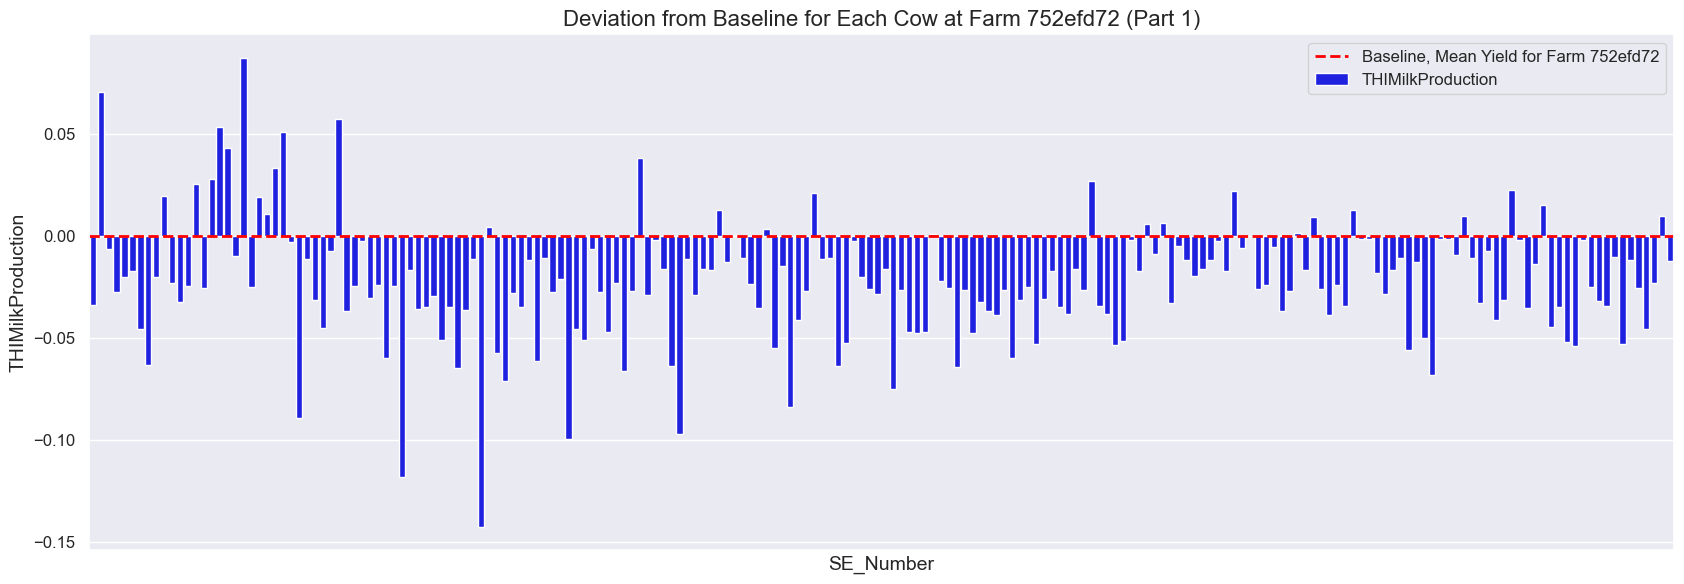

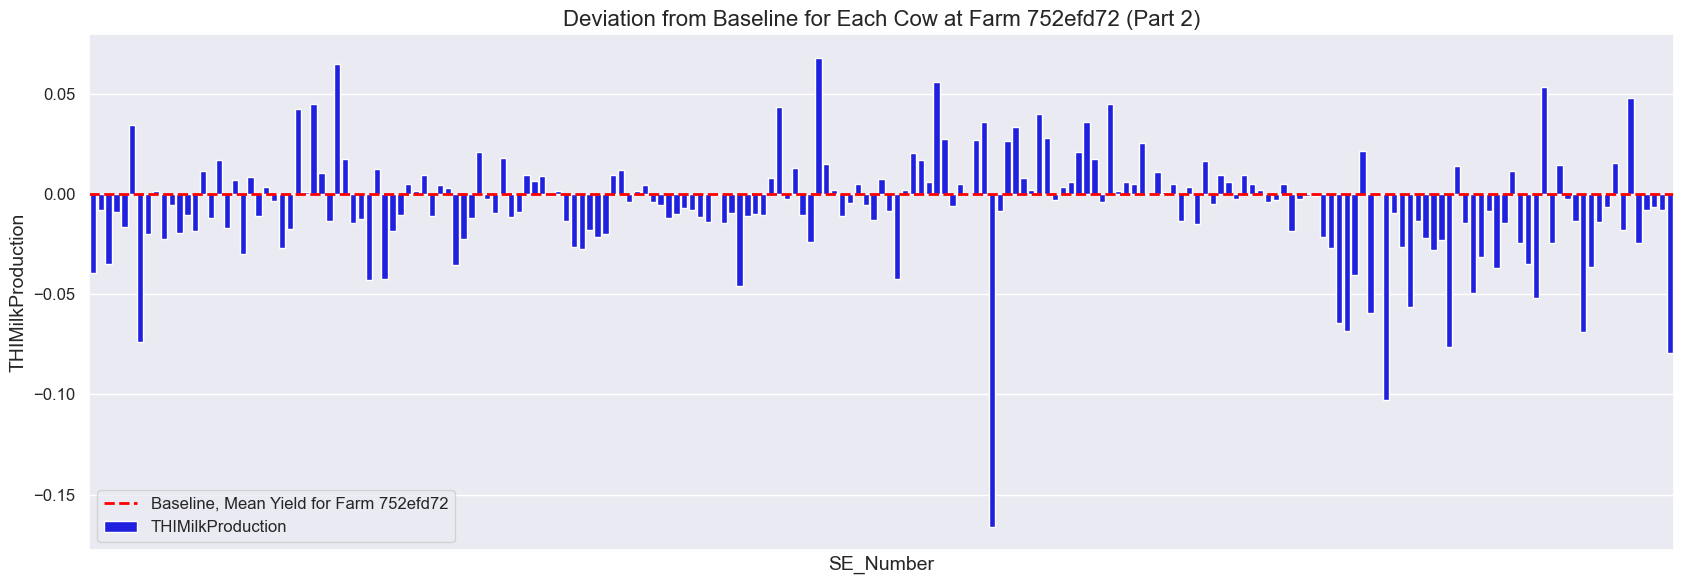

In [19]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['THIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

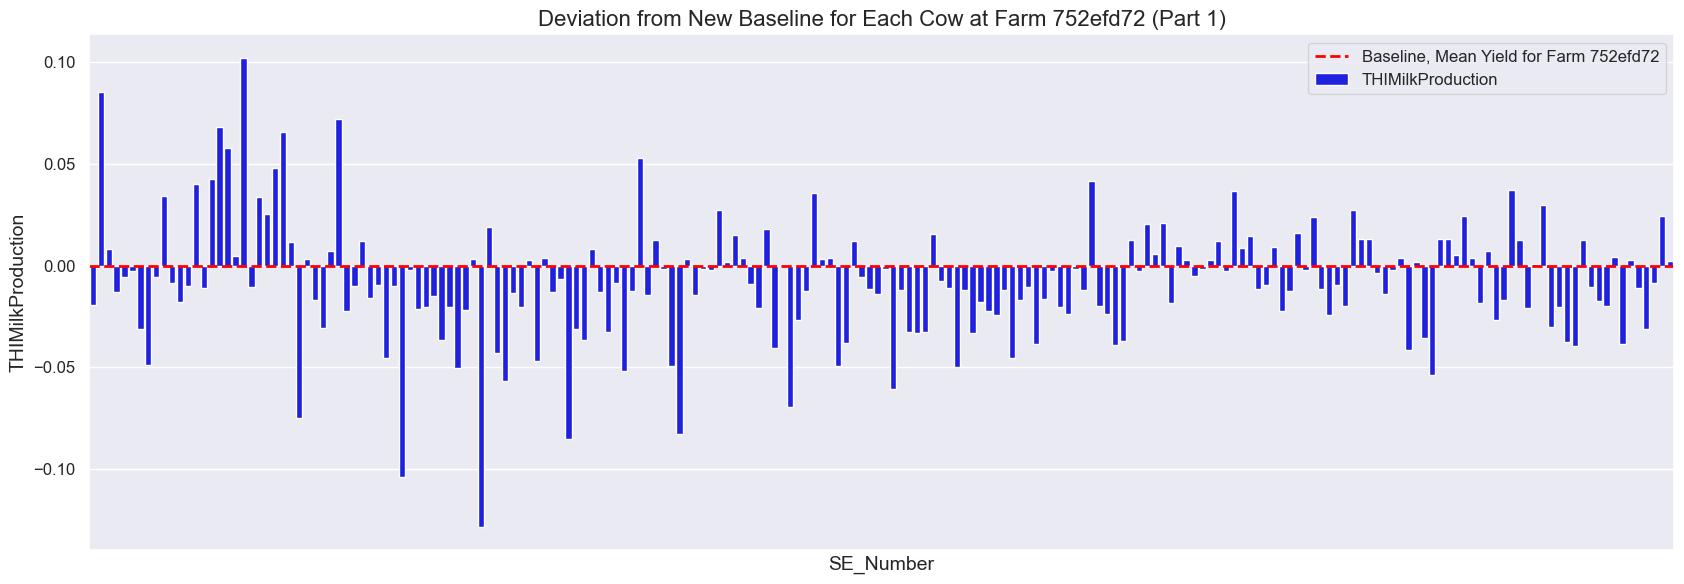

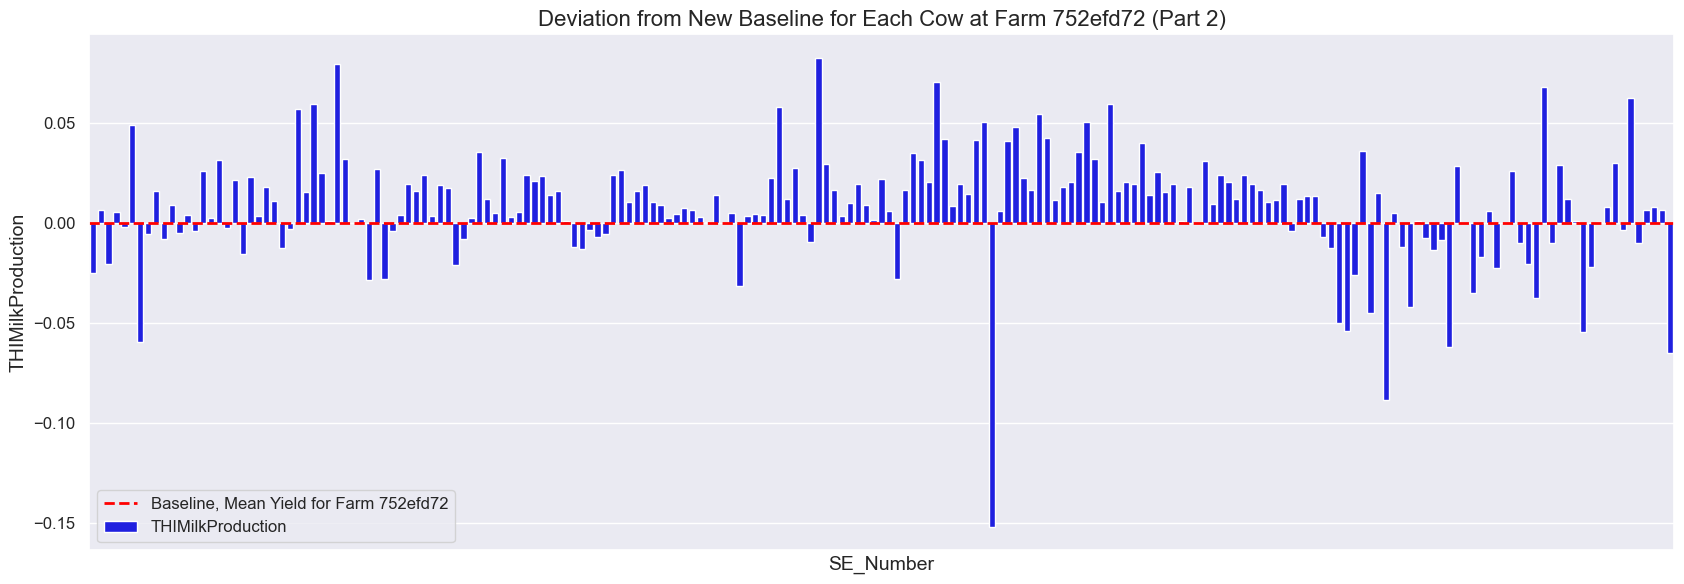

In [20]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

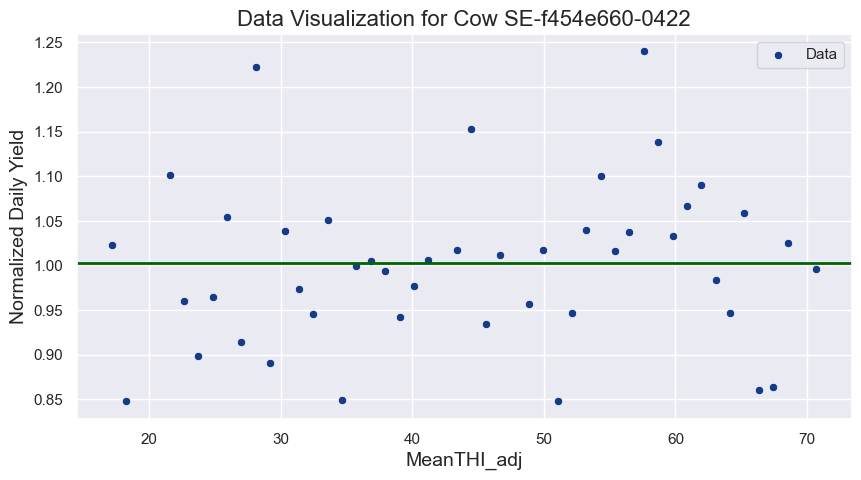

In [15]:
# Filter data for the specific farm
farm_id = 'f454e660'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

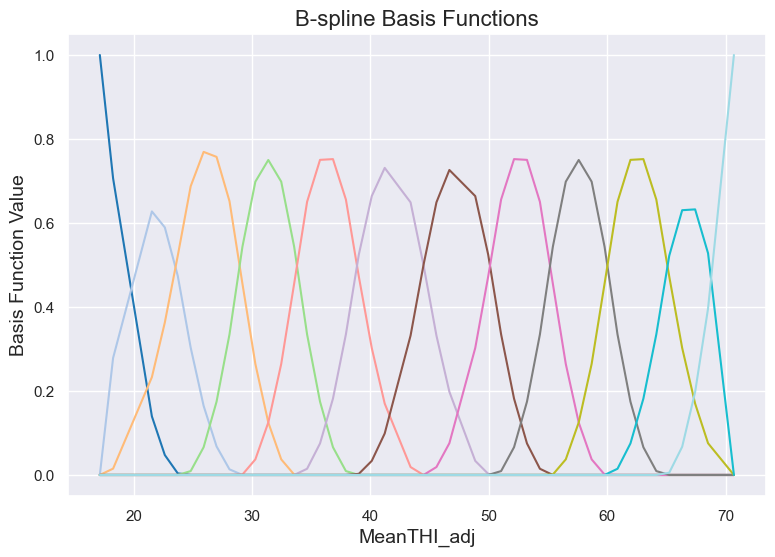

In [16]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-f454e660-0422 is 0.0056


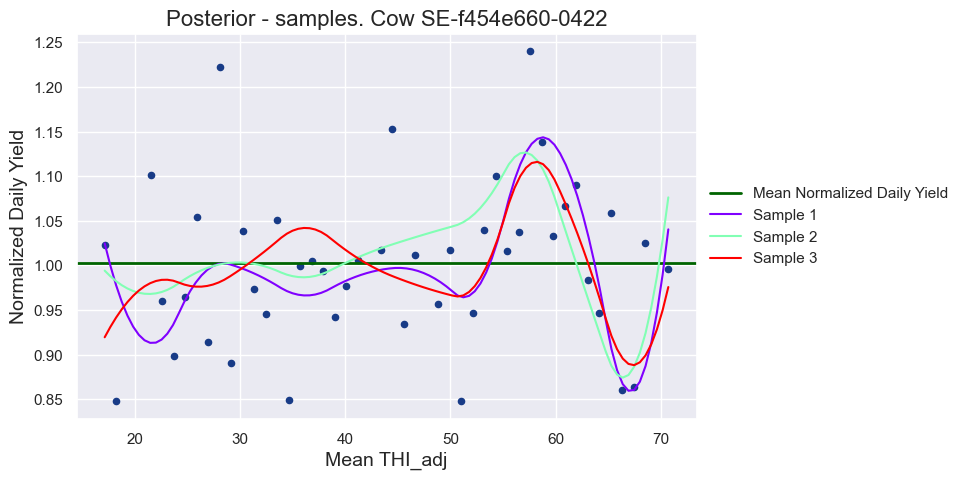

In [17]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

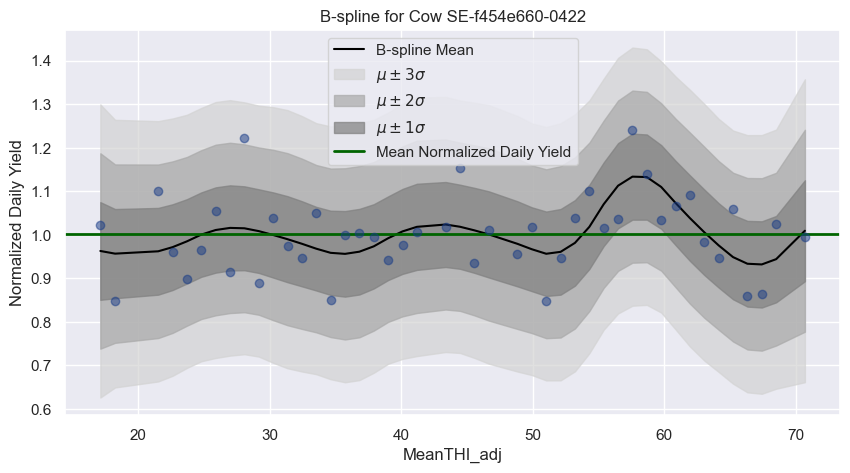

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,f454e660,SE-f454e660-0139,-4.876474,-0.048765
1,f454e660,SE-f454e660-0335,-6.614279,-0.066143
2,f454e660,SE-f454e660-0374,-2.902493,-0.029025
3,f454e660,SE-f454e660-0412,-4.569092,-0.045691
4,f454e660,SE-f454e660-0444,-2.843654,-0.028437
5,f454e660,SE-f454e660-0448,-3.536407,-0.035364
6,f454e660,SE-f454e660-0465,-3.830983,-0.038310
7,f454e660,SE-f454e660-0494,-8.358871,-0.083589
8,f454e660,SE-f454e660-0503,-9.153794,-0.091538
9,f454e660,SE-f454e660-0504,-1.084966,-0.010850


In [18]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

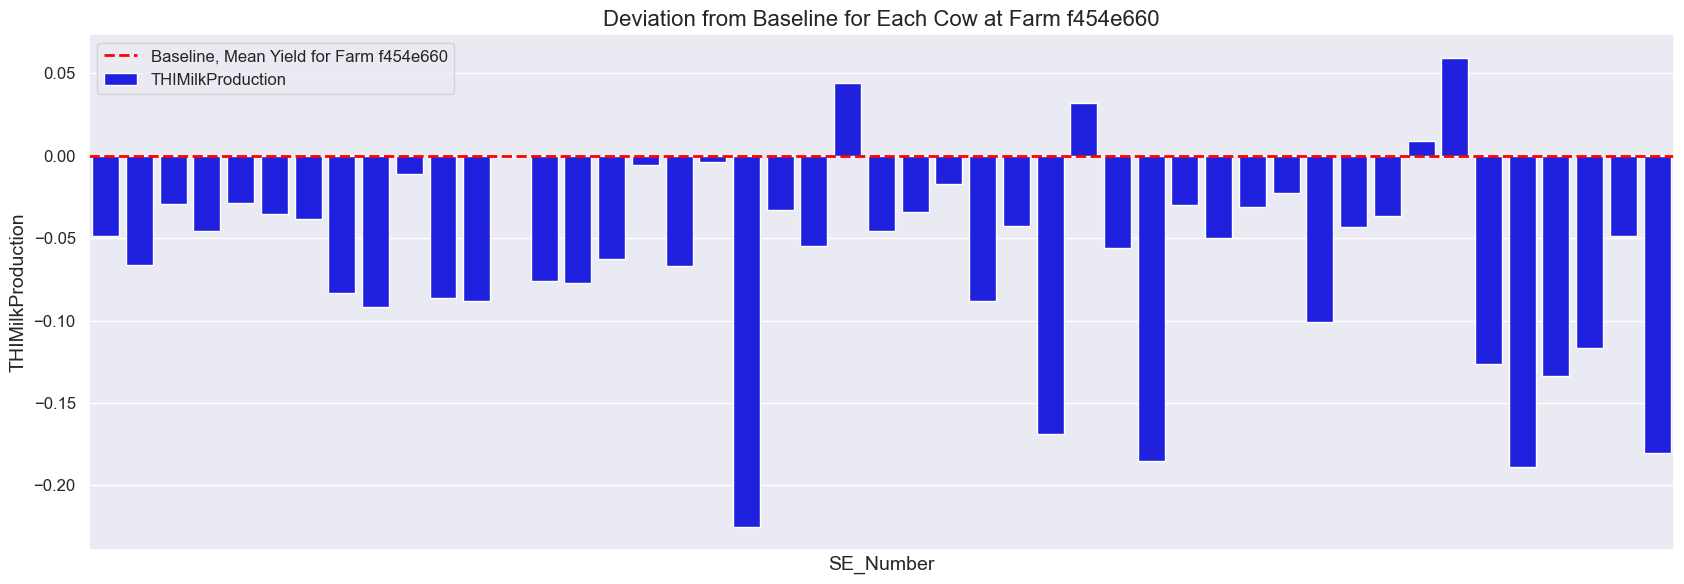

In [19]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

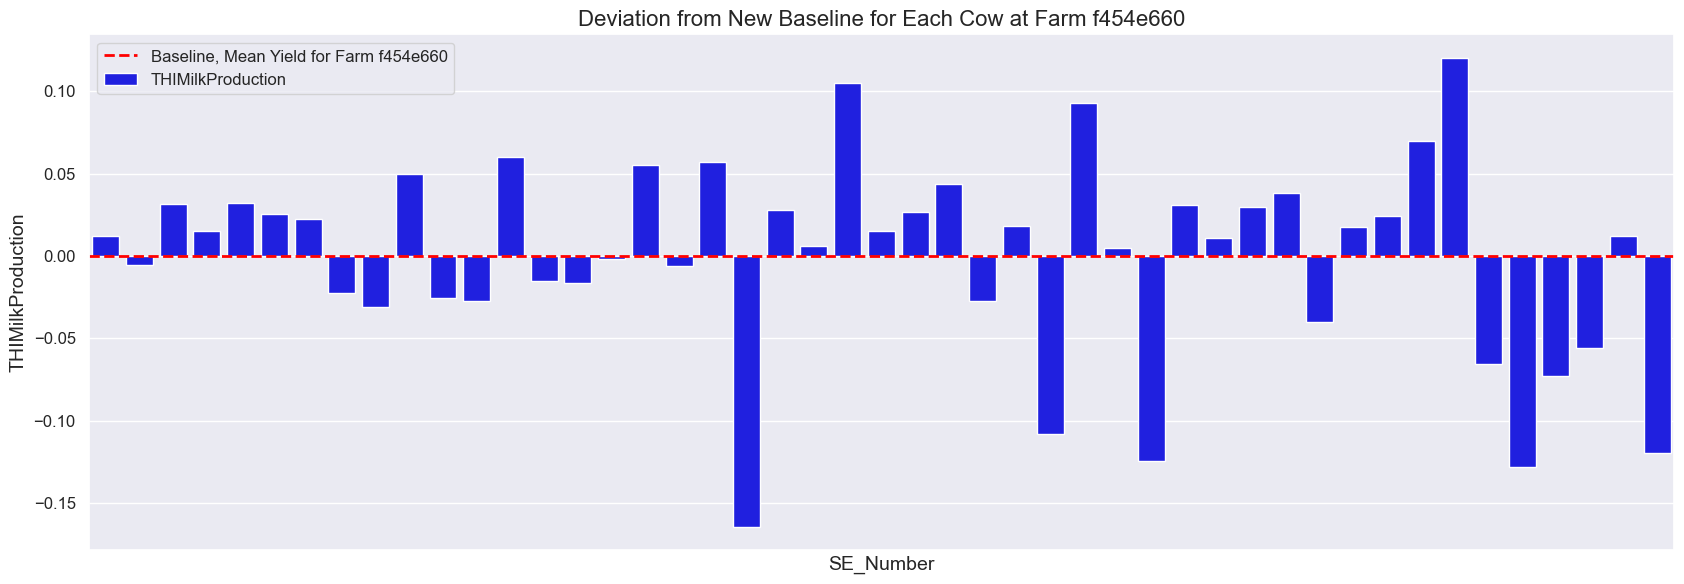

In [20]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5b581702

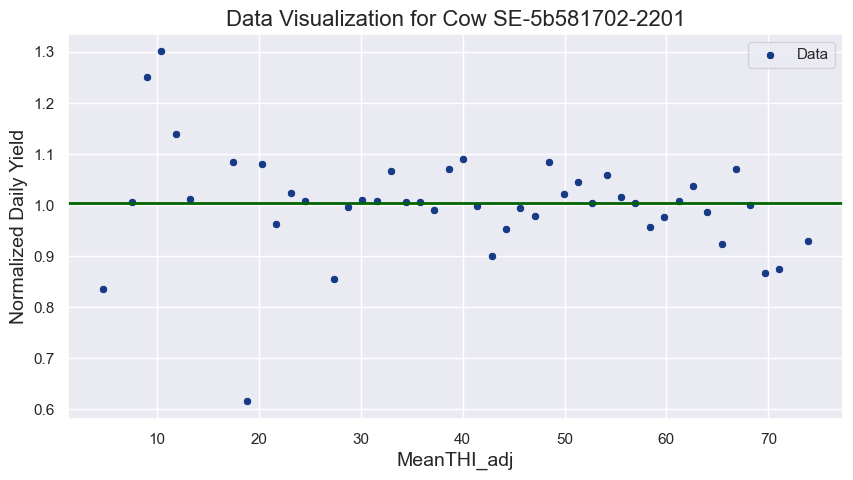

In [21]:
# Filter data for the specific farm
farm_id = '5b581702'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

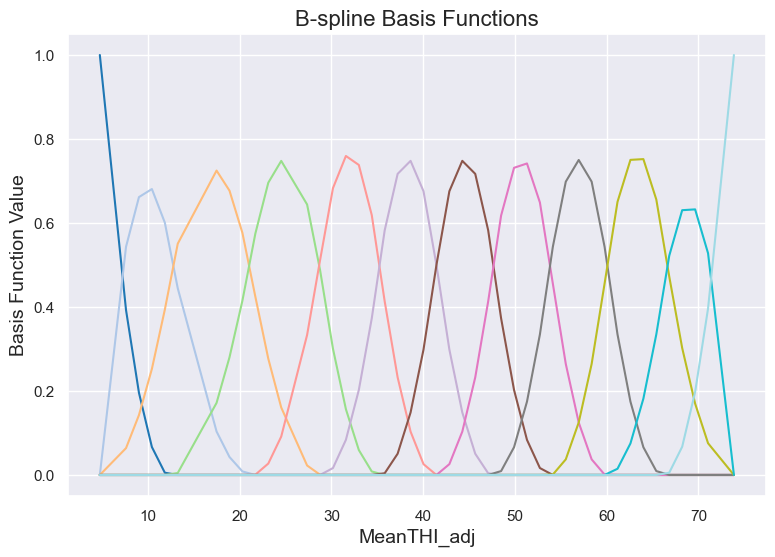

In [22]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-5b581702-2201 is 0.0056


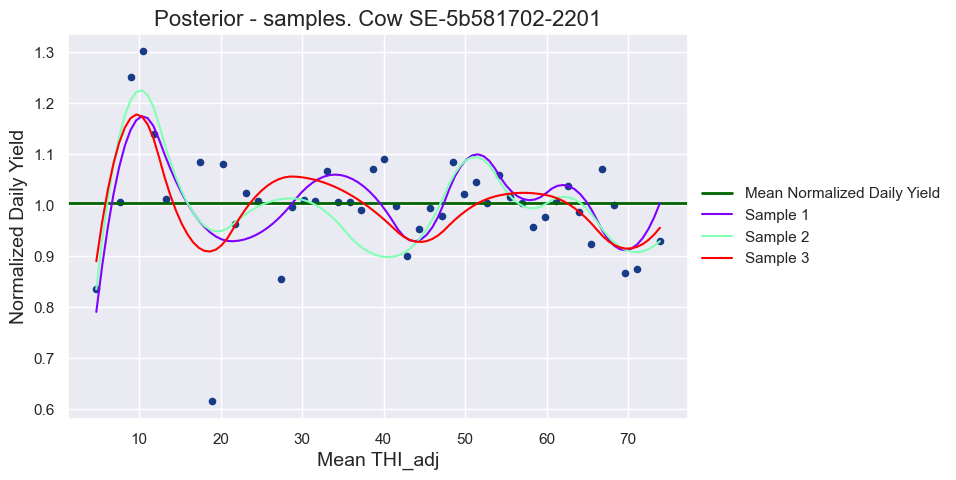

In [23]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-5b581702-2138 due to insufficient data points after filtering.


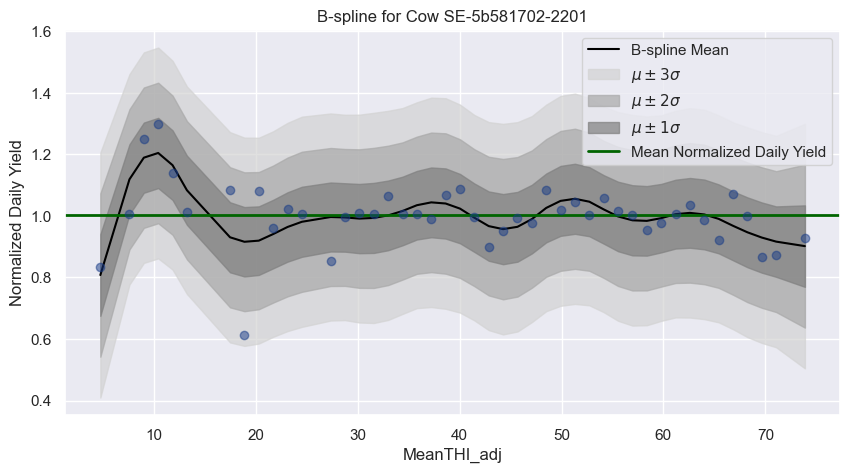

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,5b581702,SE-27c3257a-1492,-12.654968,-0.126550
1,5b581702,SE-5b581702-1755,-8.449461,-0.084495
2,5b581702,SE-5b581702-1759,5.547567,0.055476
3,5b581702,SE-5b581702-1803,-7.996399,-0.079964
4,5b581702,SE-5b581702-1816,-1.573839,-0.015738
...,...,...,...,...
56,5b581702,SE-5b581702-2104,0.110669,0.001107
57,5b581702,SE-6d38bc90-2566,1.162946,0.011629
58,5b581702,SE-6d38bc90-2590,-5.585434,-0.055854
59,5b581702,SE-6d38bc90-2592,-5.995818,-0.059958


In [24]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

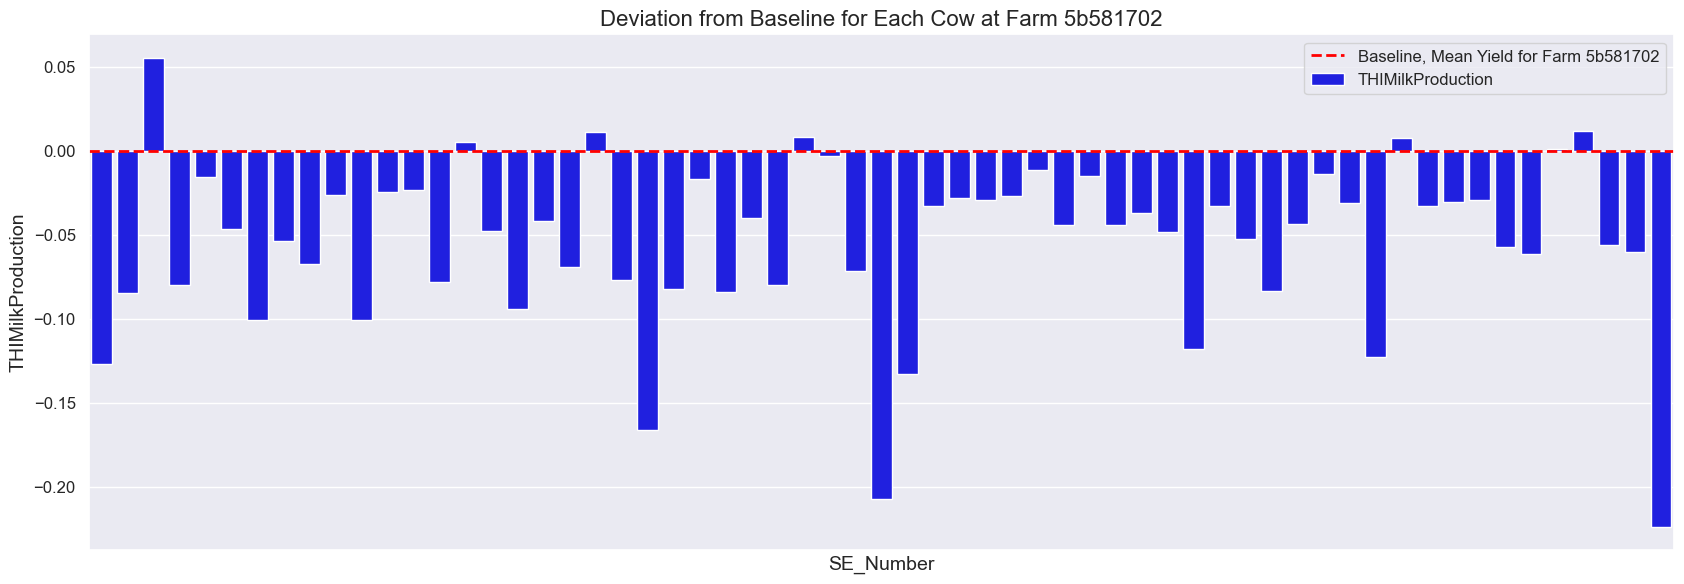

In [25]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

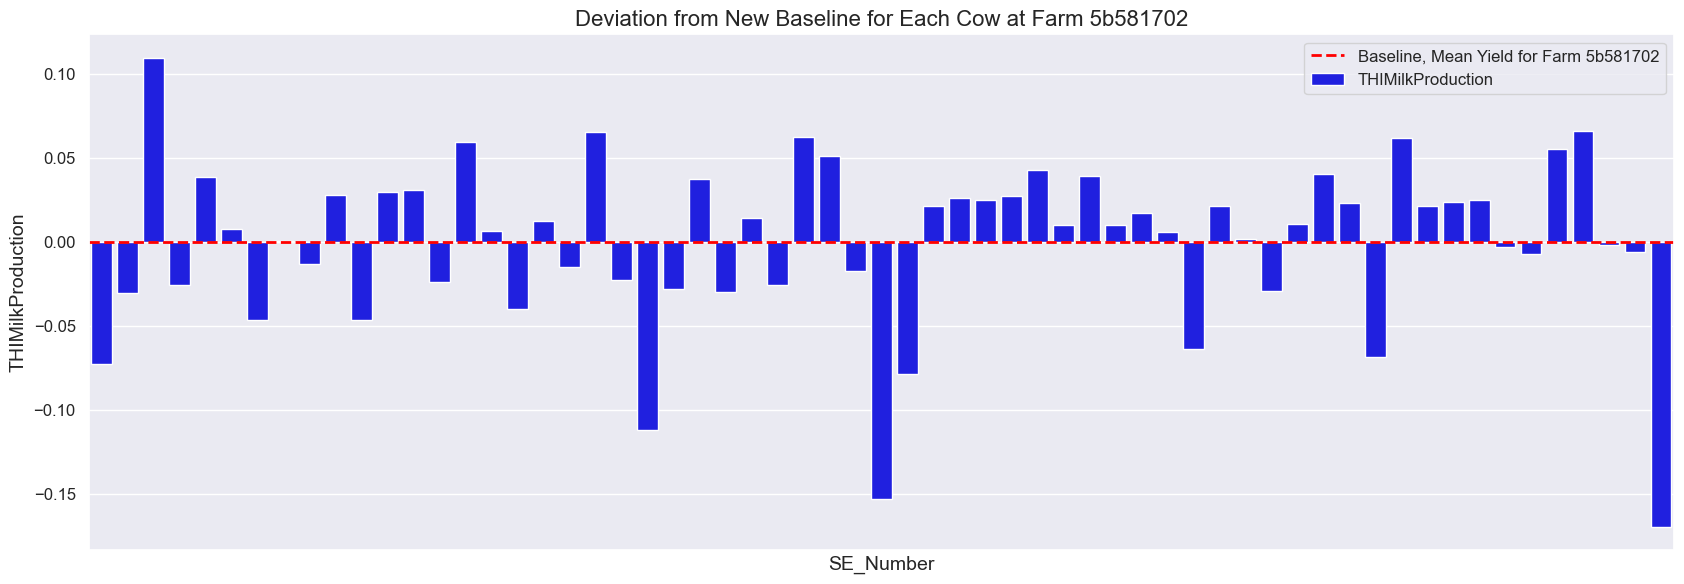

In [26]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm ad0a39f5

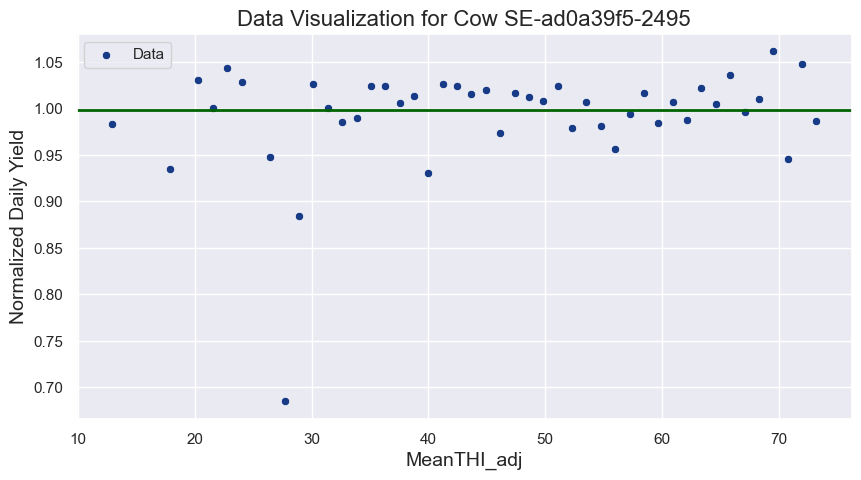

In [36]:
# Filter data for the specific farm
farm_id = 'ad0a39f5'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'MeanTHI_adj'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

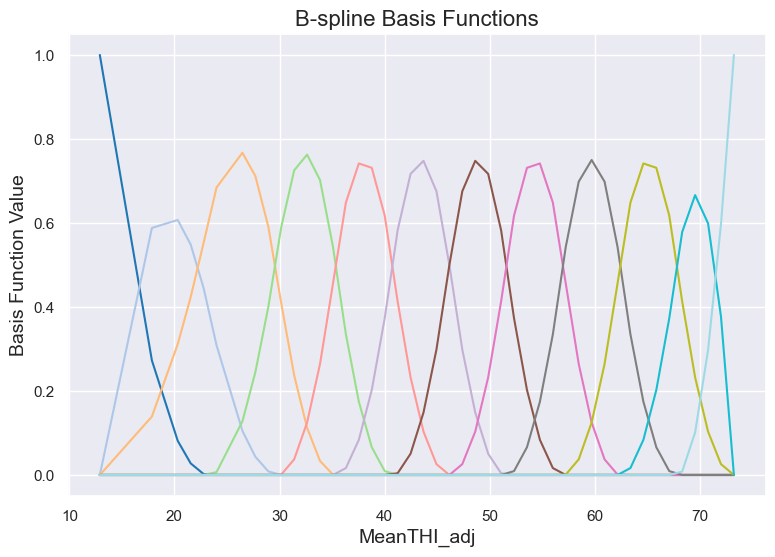

In [37]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('MeanTHI_adj', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-ad0a39f5-2495 is 0.0023


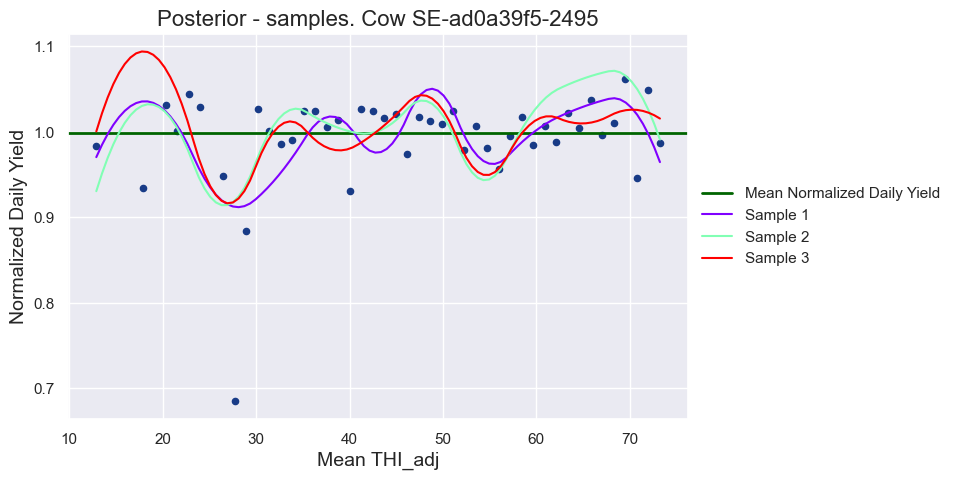

In [38]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-a756bc39-1048 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1204 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1208 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1209 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1217 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1218 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1255 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1258 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1269 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1272 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1274 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-1278 due to insufficient data points after filtering.
Skipping Cow SE-a756bc39-2851 due to insufficient da

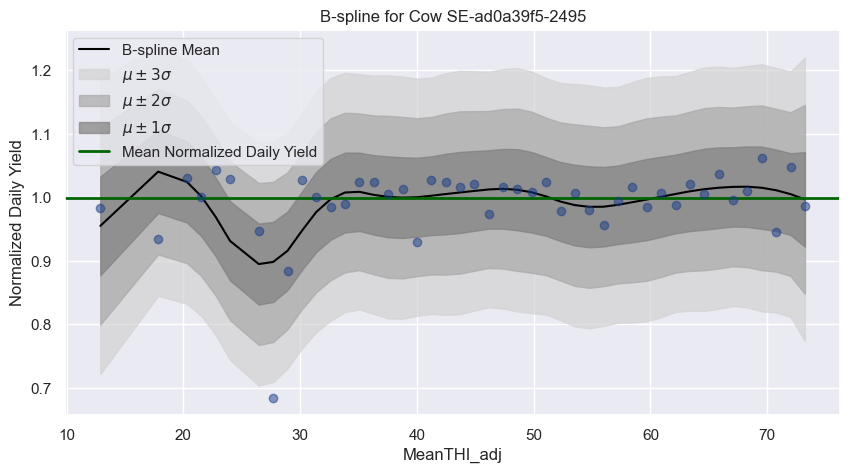

Skipping Cow SE-ad0a39f5-2536 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2581 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2593 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2612 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2622 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2626 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2632 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2650 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2656 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2726 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2729 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2741 due to insufficient data points after filtering.
Skipping Cow SE-ad0a39f5-2742 due to insufficient da

,FarmName_Pseudo,SE_Number,THIMilkProduction [%],THIMilkProduction
0,ad0a39f5,SE-a756bc39-0943,-0.881356,-0.008814
1,ad0a39f5,SE-a756bc39-1026,0.004915,0.000049
2,ad0a39f5,SE-a756bc39-1030,3.611152,0.036112
3,ad0a39f5,SE-a756bc39-1034,-1.394883,-0.013949
4,ad0a39f5,SE-a756bc39-1042,3.283104,0.032831
...,...,...,...,...
154,ad0a39f5,SE-ad0a39f5-2522,-0.122503,-0.001225
155,ad0a39f5,SE-ad0a39f5-2543,0.385382,0.003854
156,ad0a39f5,SE-ad0a39f5-2550,0.404161,0.004042
157,ad0a39f5,SE-ad0a39f5-2688,2.593223,0.025932


In [39]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'THIMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Convert bin_midpoints to numeric for comparison
    x = mean_yields[input_feature_label].values.astype(float)
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Filter x and corresponding mstar_mle for values >= 61
    filtered_indices = x >= 61  # Only include THI values >= 61
    if np.sum(filtered_indices) < 2:
        print(f"Skipping Cow {se_number} due to insufficient data points after filtering.")
        continue

    filtered_xs = x[filtered_indices]
    filtered_mstar_mle = mstar_mle[filtered_indices]

    # Integration to calculate THIMilkProduction
    above_mean = np.maximum(filtered_mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - filtered_mstar_mle, 0)

    # Integrate over the filtered x values
    area_above_mean = simpson(above_mean, x=filtered_xs)
    area_below_mean = simpson(below_mean, x=filtered_xs)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_mean_temperature = filtered_xs[-1] - filtered_xs[0]
    net_effect_per_unit = net_area / range_mean_temperature

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'THIMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['THIMilkProduction'] = results_df['THIMilkProduction [%]'] / 100
results_df

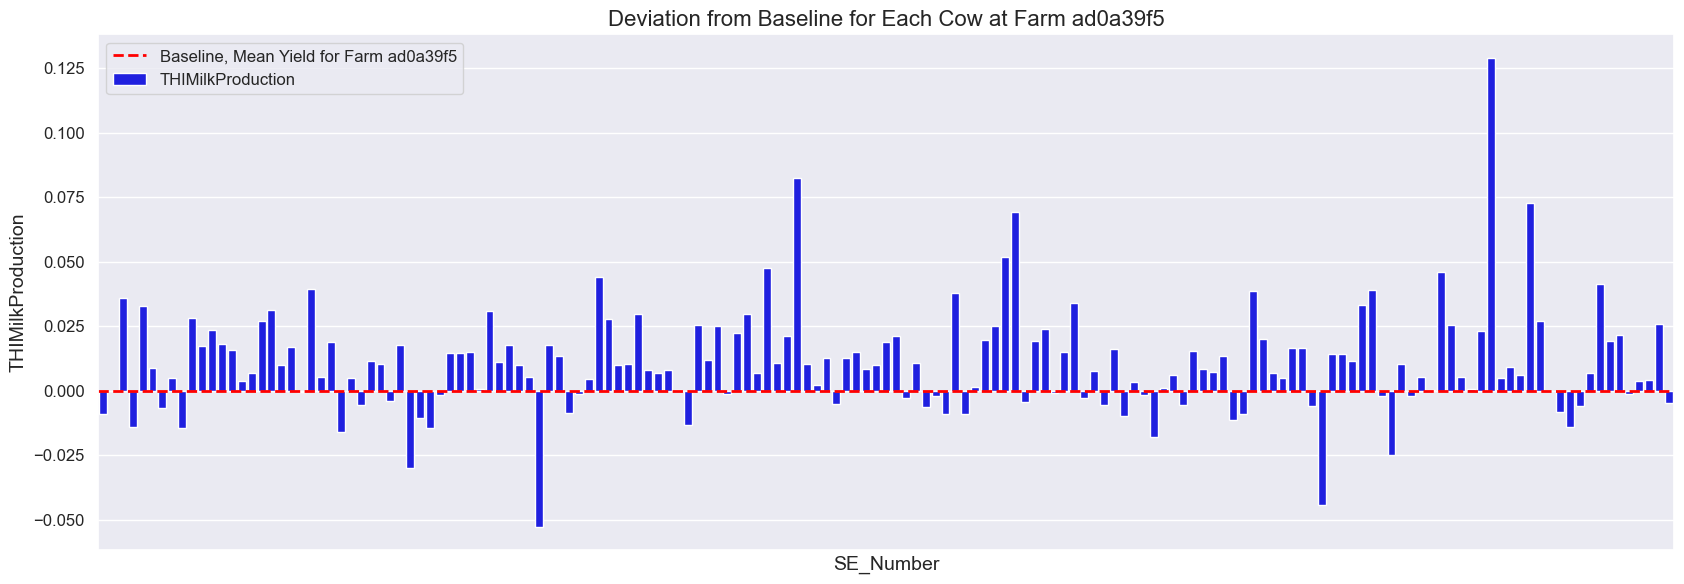

In [41]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['THIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

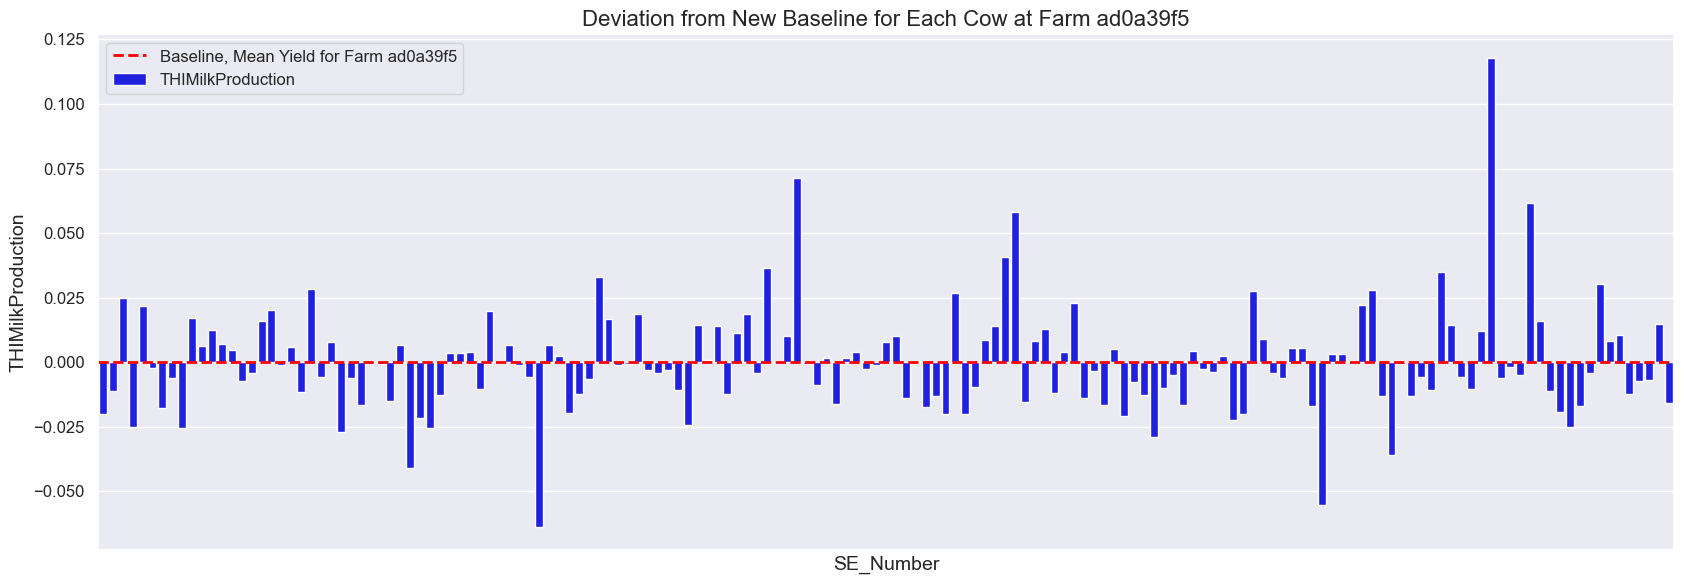

In [42]:
# New baseline value
new_baseline = results_df['THIMilkProduction'].mean()

# Adjust the THIMilkProduction to start from the new baseline
results_df['AdjustedTHIMilkProduction'] = results_df['THIMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedTHIMilkProduction'], color='blue', label='THIMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('THIMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

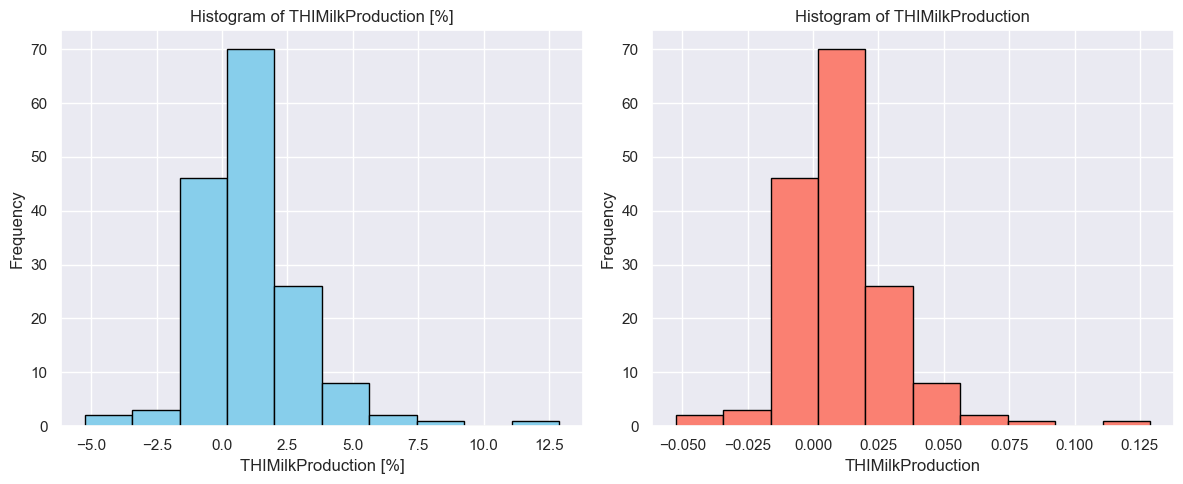

In [43]:
# Plot to see distribution
df = pd.DataFrame(results_df)
# Ensure SE_Number is a string type for better plotting labels
df['SE_Number'] = df['SE_Number'].astype(str)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for THIMilkProduction [%]
ax[0].hist(df['THIMilkProduction [%]'], bins=10, color='skyblue', edgecolor='black')
ax[0].set_title('Histogram of THIMilkProduction [%]')
ax[0].set_xlabel('THIMilkProduction [%]')
ax[0].set_ylabel('Frequency')

# Histogram for THIMilkProduction
ax[1].hist(df['THIMilkProduction'], bins=10, color='salmon', edgecolor='black')
ax[1].set_title('Histogram of THIMilkProduction')
ax[1].set_xlabel('THIMilkProduction')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()